**代码仓库：** https://github.com/arcsinY/DM_Project2
### 1. 数据集预处理
选择[Trending YouTube Video Statistics](https://www.kaggle.com/datasnaek/youtube-new)数据集进行频繁模式和关联规则挖掘。这是YouTube热门视频统计信息的数据集，包括了YouTube上热门视频的类别、频道、标题、观众喜爱数等信息。数据集中将不同国家的数据分开进行统计，这里我们仅选用美国的数据进行挖掘，包括40949条数据和16个属性，没有缺失值。
#### 1.1 数据属性
- 视频id
- trending_date，登上热榜的时间
- title，视频标题
- channel_title，频道标题
- category_id，视频类别
- publish_time，发布时间
- tags，视频附加的标签
- views，观看数量
- likes，喜爱人数
- dislikes，不喜爱人数
- comment_count，评论数量
- thumbnail_link，缩略图链接
- comments_disable，是否禁止评论
- ratings_disabled，是否禁止评分
- video_error_or_removed，是否无法观看
- description，视频描述

#### 1.2 视频类别的替换
数据集中category_id这一属性用id代表类别，id与类别的对应关系存储在US_category_id.json中，首先用实际类别替换id

In [18]:
import pandas as pd
import numpy as np
import json as js
import Orange as og
import orangecontrib.associate.fpgrowth as oaf
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [1]:
data = pd.read_csv('USvideos.csv', sep = ',')
with open('US_category_id.json') as f:   # 读取json文件
    json_date = js.load(f)
    f.close()
id2cat = {}
for i in range(len(json_date['items'])):   # id与类别对应
    id2cat[json_date['items'][i]['id']] = json_date['items'][i]['snippet']['title']
for i in range(len(data)):    # 替换
    id = data.loc[i, 'category_id']
    data.loc[i, 'category_id'] = id2cat[str(id)]
print(data['category_id'])

0          People & Blogs
1           Entertainment
2                  Comedy
3           Entertainment
4           Entertainment
               ...       
40944      Pets & Animals
40945      People & Blogs
40946       Entertainment
40947    Film & Animation
40948              Gaming
Name: category_id, Length: 40949, dtype: object


#### 1.3 属性选择与变换
只选择一部分有意义的属性进行挖掘，这里选择channel_title，category_id，tags，views，likes，dislikes，comment_count属性。其中有些属性是数值属性，不好进行关联规则的挖掘，因此将这些属性转化为标称属性。

对于views，首先计算views的四分之一分位数和四分之三分位数。大于四分之三分位数的数据记为"high view"，小于四分之一分位数的数据记为"low view"，其余的记为"medium view"。

In [2]:
arr = data['views']
one = arr.quantile(0.25)
three = arr.quantile(0.75)
view_level = []
for i in data['views']:
    if int(i) >= three:
        view_level.append('high view')
    elif int(i) <= one:
        view_level.append('low view')
    else:
        view_level.append('medium view')
print(view_level[:10])

['medium view', 'high view', 'high view', 'medium view', 'high view', 'low view', 'high view', 'medium view', 'medium view', 'medium view']


对于likes和dislikes，若likes的人数 >= dislikes的人数，则标记这个视频为"like"，否则为"dislike"

In [3]:
like = []
for i in range(len(data)):
    if data.loc[i, 'likes'] >= data.loc[i, 'dislikes']:
        like.append('like')
    else:
        like.append('dislike')
print(like[0:10])

['like', 'like', 'like', 'like', 'like', 'like', 'like', 'like', 'like', 'like']


对于comment_count，计算$\frac{comment\_count}{views}$的四分之一分位数和四分之三分位数。如果一条数据的$\frac{comment\_count}{views}$小于四分之一分位数，则记为"low comment"，若大于四分之三分位数，则记为"high comment"，其余的记为"medium comment"

In [4]:
arr = data['comment_count']
one = arr.quantile(0.25)
three = arr.quantile(0.75)
comment_level = []
for i in data['comment_count']:
    if i >= three:
        comment_level.append('high comment')
    elif i <= one:
        comment_level.append('low comment')
    else:
        comment_level.append('medium comment')
print(comment_level[0:10])

['high comment', 'high comment', 'high comment', 'medium comment', 'high comment', 'medium comment', 'medium comment', 'medium comment', 'low comment', 'medium comment']


之后将views，likes，dislikes，comment_count这四个属性替换为刚刚计算出的结果。

In [5]:
data = data.drop(['views', 'likes', 'dislikes', 'comment_count'], axis = 1)
data.insert(0, 'views', view_level)
data.insert(0, 'like', like)
data.insert(0, 'comment_count', comment_level)
# 删除不要的
data = data.drop(['video_id', 'trending_date', 'publish_time', 'video_error_or_removed', 'description', 'thumbnail_link', 'title', 'comments_disabled', 'ratings_disabled'], axis = 1)
print(data.head())

    comment_count  like  ...     category_id                                               tags
0    high comment  like  ...  People & Blogs                                    SHANtell martin
1    high comment  like  ...   Entertainment  last week tonight trump presidency|"last week ...
2    high comment  like  ...          Comedy  racist superman|"rudy"|"mancuso"|"king"|"bach"...
3  medium comment  like  ...   Entertainment  rhett and link|"gmm"|"good mythical morning"|"...
4    high comment  like  ...   Entertainment  ryan|"higa"|"higatv"|"nigahiga"|"i dare you"|"...

[5 rows x 6 columns]


### 1.4 算法输入格式转换
由于使用orangecontrib.associate.fpgrowth包进行频繁模式与关联规则挖掘时，输入的数据必须是整数类型的列表，因此需要将所有的字符串转化为整数。由于tags属性是多个tag的组合，为了能区分出不同的tag，还需将tags分割成各个tag。

In [6]:
# 算法输入格式转换（转换后输出前5条为例）
id2str = {}   # 整数编码 —> 字符串
str2id = {}   # 字符串 -> 整数编码
id = 0
transaction = []
for i in range(len(data)):
    one = []
    for j in data.columns:
        # 拆分tags
        if j == 'tags':
            str_arr = data.loc[i, j].split('|')
            for s in str_arr:
                if s in str2id:
                    one.append(str2id[s])
                else:
                    id2str[id] = s
                    str2id[s] = id
                    one.append(id)
                    id += 1
        else:
            if data.loc[i, j] in str2id:
                one.append(str2id[data.loc[i, j]])
            else:
                id2str[id] = data.loc[i, j]
                str2id[data.loc[i, j]] = id
                one.append(id)
                id += 1
    transaction.append(one)
print(transaction[:5])

[[0, 1, 2, 3, 4, 5], [0, 1, 6, 7, 8, 9, 10, 11, 12], [0, 1, 6, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37], [38, 1, 2, 39, 8, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66], [0, 1, 6, 67, 8, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 64, 65, 78, 79]]


### 2. 频繁模式挖掘
使用orangecontrib.associate.fpgrowth包进行频繁模式挖掘。首先使用默认的0.2作为频繁模式的相对支持度支持度阈值。

In [7]:
items = list(oaf.frequent_itemsets(transaction))
for i in items:
    print(i)

(frozenset({0}), 10239)
(frozenset({1}), 40373)
(frozenset({0, 1}), 10141)
(frozenset({2}), 20472)
(frozenset({1, 2}), 20263)
(frozenset({6}), 10238)
(frozenset({1, 6}), 10205)
(frozenset({8}), 9964)
(frozenset({8, 1}), 9808)
(frozenset({38}), 20460)
(frozenset({1, 38}), 20256)
(frozenset({2, 38}), 15081)
(frozenset({1, 2, 38}), 14974)
(frozenset({80}), 10239)
(frozenset({80, 1}), 9905)
(frozenset({144}), 10250)
(frozenset({144, 1}), 9976)


在输出结果中，frozenset是项集，后面的数字是这个项集的绝对支持度。为了更好地显示频繁项集，下面将数字重新转化为原始的字符串，同时计算相对支持度（保留两位小数）。

In [8]:
for i in items:
    freq_set = []
    abs_sup = i[1]
    for j in i[0]:
        freq_set.append(id2str[j])
    print(freq_set, abs_sup, round(float(abs_sup) / len(data), 2))

['high comment'] 10239 0.25
['like'] 40373 0.99
['high comment', 'like'] 10141 0.25
['medium view'] 20472 0.5
['like', 'medium view'] 20263 0.49
['high view'] 10238 0.25
['like', 'high view'] 10205 0.25
['Entertainment'] 9964 0.24
['Entertainment', 'like'] 9808 0.24
['medium comment'] 20460 0.5
['like', 'medium comment'] 20256 0.49
['medium view', 'medium comment'] 15081 0.37
['like', 'medium view', 'medium comment'] 14974 0.37
['low view'] 10239 0.25
['low view', 'like'] 9905 0.24
['low comment'] 10250 0.25
['low comment', 'like'] 9976 0.24


改用0.3作为相对支持度阈值，再次计算频繁项集

In [9]:
items = list(oaf.frequent_itemsets(transaction, 0.3))
for i in items:
    freq_set = []
    abs_sup = i[1]
    for j in i[0]:
        freq_set.append(id2str[j])
    print(freq_set, abs_sup, round(float(abs_sup) / len(data), 2))

['like'] 40373 0.99
['medium view'] 20472 0.5
['like', 'medium view'] 20263 0.49
['medium comment'] 20460 0.5
['like', 'medium comment'] 20256 0.49
['medium view', 'medium comment'] 15081 0.37
['like', 'medium view', 'medium comment'] 14974 0.37


### 3. 关联规则挖掘
在计算出频繁项集的基础上，计算关联规则，置信度阈值选择为0.2。结果转化为原始字符串输出，置信度保留两位小数

In [10]:
# 关联规则
items = list(oaf.frequent_itemsets(transaction, 0.2))
rules = list(oaf.association_rules(dict(items), 0.2))
for i in rules:
    antecedent = []
    consequent = []
    for j in i[0]:
        antecedent.append(id2str[j])
    for j in i[1]:
        consequent.append(id2str[j])
    print(antecedent, "->", consequent, i[2], round(i[3],2))
print(len(rules))

['medium view', 'medium comment'] -> ['like'] 14974 0.99
['like', 'medium comment'] -> ['medium view'] 14974 0.74
['medium comment'] -> ['like', 'medium view'] 14974 0.73
['like', 'medium view'] -> ['medium comment'] 14974 0.74
['medium view'] -> ['like', 'medium comment'] 14974 0.73
['like'] -> ['medium view', 'medium comment'] 14974 0.37
['like'] -> ['high comment'] 10141 0.25
['high comment'] -> ['like'] 10141 0.99
['medium view'] -> ['like'] 20263 0.99
['like'] -> ['medium view'] 20263 0.5
['high view'] -> ['like'] 10205 1.0
['like'] -> ['high view'] 10205 0.25
['like'] -> ['Entertainment'] 9808 0.24
['Entertainment'] -> ['like'] 9808 0.98
['medium comment'] -> ['like'] 20256 0.99
['like'] -> ['medium comment'] 20256 0.5
['medium comment'] -> ['medium view'] 15081 0.74
['medium view'] -> ['medium comment'] 15081 0.74
['like'] -> ['low view'] 9905 0.25
['low view'] -> ['like'] 9905 0.97
['like'] -> ['low comment'] 9976 0.25
['low comment'] -> ['like'] 9976 0.97
22


共得到22条关联规则，在第5节中将对这些规则进行分析。

### 4. 关联规则的评价
虽然已经得到了频繁项集的支持度、关联规则的支持度和置信度，但由于数据的分布不均，这些关联规则可能不准确。使用Lift和Kulc两种评价指标评价关联规则。

#### 4.1 Lift的计算

In [11]:
measure = list(oaf.rules_stats(oaf.association_rules(dict(items), 0.2), dict(oaf.frequent_itemsets(transaction, 0.2)), len(data)))
for i in measure:
    antecedent = []
    consequent = []
    for j in i[0]:
        antecedent.append(id2str[j])
    for j in i[1]:
        consequent.append(id2str[j])
    print(antecedent, "->", consequent, round(i[6], 2))

['medium view', 'medium comment'] -> ['like'] 1.01
['like', 'medium comment'] -> ['medium view'] 1.48
['medium comment'] -> ['like', 'medium view'] 1.48
['like', 'medium view'] -> ['medium comment'] 1.48
['medium view'] -> ['like', 'medium comment'] 1.48
['like'] -> ['medium view', 'medium comment'] 1.01
['like'] -> ['high comment'] 1.0
['high comment'] -> ['like'] 1.0
['medium view'] -> ['like'] 1.0
['like'] -> ['medium view'] 1.0
['high view'] -> ['like'] 1.01
['like'] -> ['high view'] 1.01
['like'] -> ['Entertainment'] 1.0
['Entertainment'] -> ['like'] 1.0
['medium comment'] -> ['like'] 1.0
['like'] -> ['medium comment'] 1.0
['medium comment'] -> ['medium view'] 1.47
['medium view'] -> ['medium comment'] 1.47
['like'] -> ['low view'] 0.98
['low view'] -> ['like'] 0.98
['like'] -> ['low comment'] 0.99
['low comment'] -> ['like'] 0.99


#### 4.2 Kulczynski (Kulc)的计算
根据Kulc的计算公式：$Kulc(A,B) = \frac{1}{2}\times (\frac{s(A\cup B)}{s(A)} + \frac{s(A\cup B)}{s(B)})$，即A->B的规则与B->A的规则的置信度的平均值。观察到所有找出的关联规则都包含对应的反向的规则，即$\forall A\rightarrow B\in rules, B\rightarrow A\in rules$，因此直接在现有的关联规则中计算Kulc

In [84]:
# 计算Kulc
kulc = []
visit = [False for i in range(len(rules))]
for i in range(len(rules)):
    if visit[i] == True:
        continue
    visit[i] = True
    for j in range(len(rules)):
        if visit[j] == True:
            continue
        if rules[j][0] == rules[i][1] and rules[j][1] == rules[i][0]:
            one = []
            antecedent = []
            consequent = []
            for k in rules[i][0]:
                antecedent.append(id2str[k])
            for k in rules[i][1]:
                consequent.append(id2str[k])
            one.append(rules[i][0])
            one.append(rules[i][1])
            one.append((rules[i][3] + rules[j][3])/2)
            kulc.append(one)
            print('Kulc(', antecedent, consequent, ') = ', round((rules[i][3] + rules[j][3])/2, 2))
            visit[j] = True

Kulc( ['medium view', 'medium comment'] ['like'] ) =  0.68
Kulc( ['like', 'medium comment'] ['medium view'] ) =  0.74
Kulc( ['medium comment'] ['like', 'medium view'] ) =  0.74
Kulc( ['like'] ['high comment'] ) =  0.62
Kulc( ['medium view'] ['like'] ) =  0.75
Kulc( ['high view'] ['like'] ) =  0.62
Kulc( ['like'] ['Entertainment'] ) =  0.61
Kulc( ['medium comment'] ['like'] ) =  0.75
Kulc( ['medium comment'] ['medium view'] ) =  0.74
Kulc( ['like'] ['low view'] ) =  0.61
Kulc( ['like'] ['low comment'] ) =  0.61


### 5. 挖掘结果的分析
lift可以用于衡量关联规则中两个项目的相关度，$lift(A,B)>1$说明A与B正相关，$=1$说明相互独立，$<1$说明负相关。在所有的22条关联规则中，lift值大于1的只有6条（有两条的lift = 1.01，这里近似认为其等于1），分别是：

['like', 'medium comment'] -> ['medium view'] 1.48  
['medium comment'] -> ['like', 'medium view'] 1.48  
['like', 'medium view'] -> ['medium comment'] 1.48  
['medium view'] -> ['like', 'medium comment'] 1.48  
['medium comment'] -> ['medium view'] 1.47  
['medium view'] -> ['medium comment'] 1.47  

再来看看这6条规则的Kulc值：

Kulc( ['like', 'medium comment'] ['medium view'] ) =  0.7353379092284642  
Kulc( ['medium comment'] ['like', 'medium view'] ) =  0.7354247196772028  
Kulc( ['medium comment'] ['medium view'] ) =  0.7368807434859888  

在所有计算出的关联规则的Kulc值中，这三个Kulc值属于比较大的。因此可以认为这6条关联规则是可以接受的。可以得到结论：
1. 观众喜爱的，且评论数量中等的，会有中等的观看量
2. 观众喜爱的，且观看量中等的，会有中等的评论量
3. 中等的观看量的视频会有中等评论量
以上三条结论，反过来也成立。

在关联规则中，有一条的置信度很高：

['low view'] -> ['like'] 9905 0.97

这条规则说明观看量少的，观众会喜爱，这与我们的尝试不符。这条规则的Lift值为0.98，说明这两项实际上是负相关的Kulc值为0.606，是所有Kulc值中最小的。说明这条关联规则是具有误导性的，推测原因是因为"like"项或"low view"项出现次数太多。

In [16]:
# "like" 数量和 "low view" 数量
like_cnt = 0
low_view_cnt = 0
for i in data['like']:
    if i == 'like':
        like_cnt += 1
for i in data['views']:
    if i == 'low view':
        low_view_cnt += 1
print(like_cnt, low_view_cnt)

40373 10239


在40949条数据中，有40373项"like"，占到了98.6%。因此导致出现了有误导性的关于"like"的关联规则

### 6. 可视化展示
使用matplotlib绘制关联规则的置信度、Lift和Kulc相关性热图。

热图的横纵坐标是关联规则中包含的项（共11项），热图中每个点的数据是两项的置信度、Lift值或Kulc值，若这两项不包括在关联规则中，则对应的值记为0

首先利用置信度绘制热图。

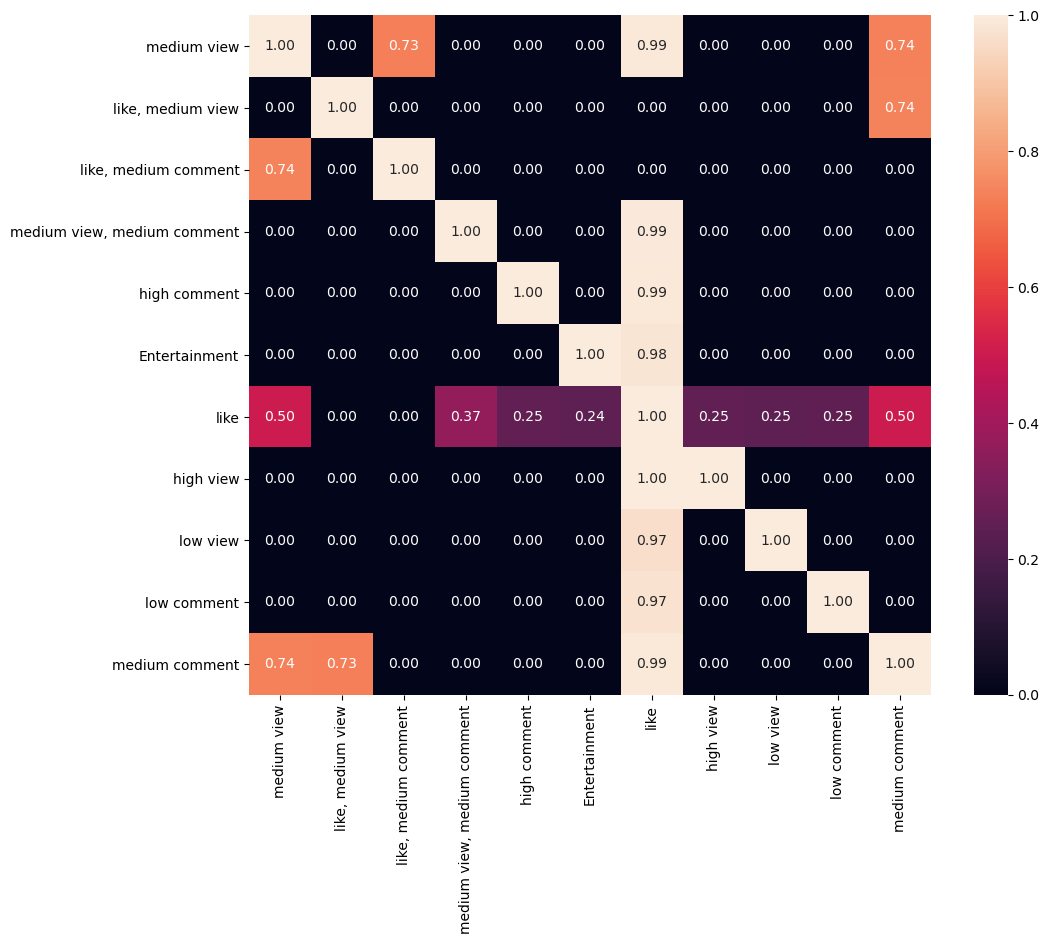

In [76]:
# 可视化
conf_matrix = []
rules_column = set()

for i in range(len(measure)):
    rules_column.add(measure[i][0])
# 计算置信度矩阵
for i in rules_column:
    one = []
    for j in rules_column:
        if i == j:
            one.append(1)
        else:
            flag = False
            for k in range(len(rules)):
                if rules[k][0] == i and rules[k][1] == j:
                    one.append(rules[k][3])
                    flag = True
            if flag == False:
                one.append(0)
    conf_matrix.append(one)
# 改columns名字
rules_column_list = []
for i in rules_column:
    one = ""
    for j in range(len(i)):
        one += id2str[j]
        if j < len(i) - 1:
            one += ", "
    rules_column_list.append(one)
# 绘制热图的数据
rules_column = list(rules_column)
rules_column_list = []
for i in rules_column:
    one = ""
    for j in range(len(i)):
        one += id2str[list(i)[j]]
        if j < len(i) - 1:
            one += ", "
    rules_column_list.append(one)

conf_pd = pd.DataFrame(conf_matrix, columns = rules_column_list, index = rules_column_list)
plt.figure(figsize=(11, 9),dpi=100)
sns.heatmap(data = conf_pd, annot = True, fmt = ".2f")
plt.show()

下面使用Lift值绘制热图

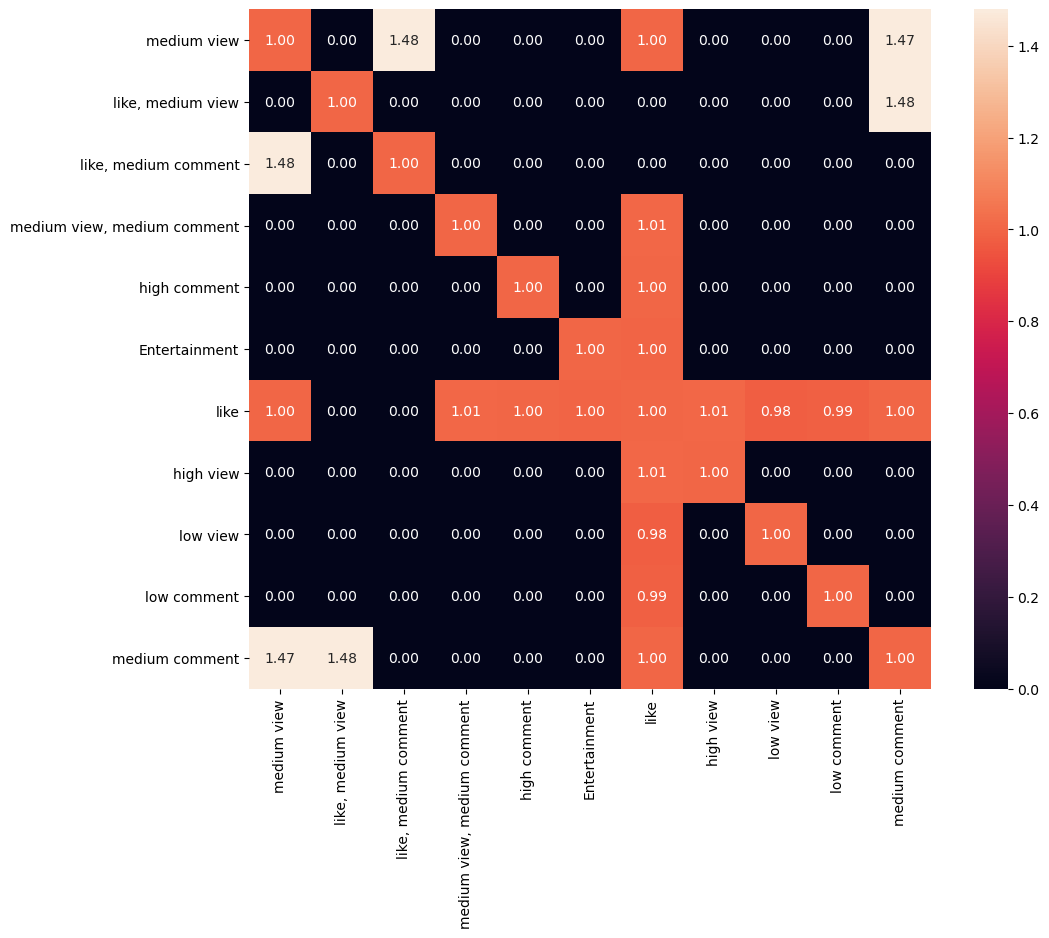

In [72]:
# 计算lift矩阵
lift_matrix = []
for i in rules_column:
    one = []
    for j in rules_column:
        if i == j:
            one.append(1)
        else:
            flag = False
            for k in range(len(measure)):
                if measure[k][0] == i and measure[k][1] == j:
                    one.append(measure[k][6])
                    flag = True
            if flag == False:
                one.append(0)
    lift_matrix.append(one)

lift_pd = pd.DataFrame(lift_matrix, columns = rules_column_list, index = rules_column_list)
plt.figure(figsize=(11, 9),dpi=100)
sns.heatmap(data = lift_pd, annot = True, fmt = ".2f")
plt.show()

下面使用Kulc值绘制热图

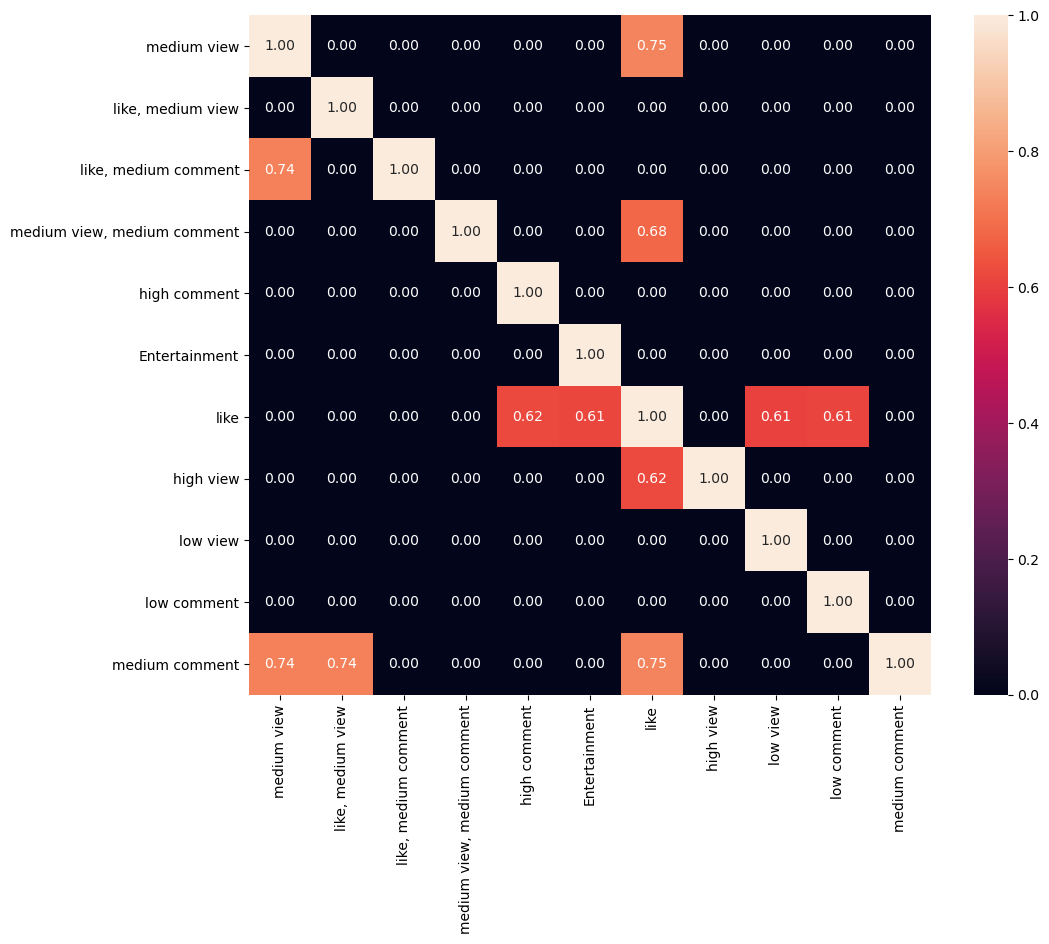

In [87]:
kulc_matrix = []
# 计算kulc矩阵
for i in rules_column:
    one = []
    for j in rules_column:
        if i == j:
            one.append(1)
        else:
            flag = False
            for k in range(len(kulc)):
                if kulc[k][0] == i and kulc[k][1] == j:
                    one.append(kulc[k][2])
                    flag = True
            if flag == False:
                one.append(0)
    kulc_matrix.append(one)
    
kulc_pd = pd.DataFrame(kulc_matrix, columns = rules_column_list, index = rules_column_list)
plt.figure(figsize=(11, 9),dpi=100)
sns.heatmap(data = kulc_pd, annot = True, fmt = ".2f")
plt.show()